In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.postprocess import post_process
from utils.set_seed import seed_base
from feature_engineering.fe_xgb import generate_features

MODEL_NAME = "xgb_model"
PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-11-02 17:15:49.953786: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-02 17:15:50.367650: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-02 17:15:51.496530: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_114


In [2]:
# 特徴生成
files = glob(f"{CFG['dataset']['step_csv_dir_5min']}/*.parquet")
train, features = generate_features(files)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

generate features: 100%|██████████| 277/277 [04:12<00:00,  1.10it/s]


,anglez,anglez_diff_abs,anglez_diff_abs_clip5,anglez_mean,enmo,enmo_diff_abs,enmo_mean,minutes,same_count,total_seconds,...,enmo_rolling_median_100_shift_1000,anglez_diff_abs_clip5_rolling_median_100_shift_1000,enmo_std_rolling_median_100_shift_1000,anglez_diff_abs_clip5_std_rolling_median_100_shift_1000,enmo_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_rolling_square_mean_100_shift_1000,enmo_std_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_std_rolling_square_mean_100_shift_1000,reduce_step,fold
926,21.070280,21.889490,4.451904,-20.794807,0.027129,0.014742,0.037067,477.5,0.0,68877.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22235,3
927,-2.156629,17.598087,3.993946,-21.465599,0.091583,0.079287,0.072814,597.5,0.0,68997.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22259,3
928,6.870979,16.874817,4.571238,-17.906569,0.048471,0.023354,0.085562,717.5,0.0,69117.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22283,3
929,11.430203,8.910088,3.756421,-5.006313,0.029496,0.013204,0.031394,837.5,0.0,69237.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22307,3
930,10.291650,2.129946,1.981583,-21.022831,0.003008,0.001954,0.058677,957.5,0.0,69357.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,22331,3


(494843, 1307)

In [3]:
# 学習
dfs = []
for event in ["wakeup", "onset"]:
    trn_oof, models = fit_xgb(
        X=train, 
        y=train[f"{event}_target"], 
        folds=train["fold"].astype(int), 
        features=features.all_features(),
        params=CFG[MODEL_NAME]["xgboost"], 
        es_rounds=100,
    )
    train["score"] = trn_oof
    train["event"] = event
    dfs.append(train[["series_id", "step", "score", "event"]])

    # 保存
    for i, model in enumerate(models):
        model.save_model(os.path.join(CFG["output_dir"], f'xgb_{event}_fold_{i}.model'))
del train
gc.collect()
train = pd.concat(dfs, axis=0)
train["step"] = train["step"].astype(int)
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)


with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.00808
[100]	eval-rmse:0.75315
[200]	eval-rmse:0.68848
[300]	eval-rmse:0.67052
[400]	eval-rmse:0.66456
[500]	eval-rmse:0.66215
[600]	eval-rmse:0.66085
[700]	eval-rmse:0.65982
[800]	eval-rmse:0.65920
[900]	eval-rmse:0.65853
[1000]	eval-rmse:0.65826
[1100]	eval-rmse:0.65805
[1200]	eval-rmse:0.65779
[1300]	eval-rmse:0.65762
[1400]	eval-rmse:0.65745
[1500]	eval-rmse:0.65735
[1600]	eval-rmse:0.65732
[1700]	eval-rmse:0.65721
[1800]	eval-rmse:0.65710
[1900]	eval-rmse:0.65705
[2000]	eval-rmse:0.65695
[2100]	eval-rmse:0.65690
[2200]	eval-rmse:0.65689
[2263]	eval-rmse:0.65690


 20%|██        | 1/5 [01:24<05:36, 84.24s/it]

== fold 1 ==
[0]	eval-rmse:1.05342
[100]	eval-rmse:0.80789
[200]	eval-rmse:0.74664
[300]	eval-rmse:0.72989
[400]	eval-rmse:0.72299
[500]	eval-rmse:0.72004
[600]	eval-rmse:0.71852
[700]	eval-rmse:0.71768
[800]	eval-rmse:0.71697
[900]	eval-rmse:0.71639
[1000]	eval-rmse:0.71596
[1100]	eval-rmse:0.71571
[1200]	eval-rmse:0.71543
[1300]	eval-rmse:0.71511
[1400]	eval-rmse:0.71502
[1500]	eval-rmse:0.71482
[1600]	eval-rmse:0.71470
[1700]	eval-rmse:0.71446
[1800]	eval-rmse:0.71428
[1900]	eval-rmse:0.71422
[2000]	eval-rmse:0.71407
[2100]	eval-rmse:0.71405
[2200]	eval-rmse:0.71387
[2300]	eval-rmse:0.71381
[2400]	eval-rmse:0.71378
[2467]	eval-rmse:0.71376


 40%|████      | 2/5 [02:54<04:23, 87.68s/it]

== fold 2 ==
[0]	eval-rmse:1.03625
[100]	eval-rmse:0.79690
[200]	eval-rmse:0.73816
[300]	eval-rmse:0.72138
[400]	eval-rmse:0.71516
[500]	eval-rmse:0.71291
[600]	eval-rmse:0.71137
[700]	eval-rmse:0.71054
[800]	eval-rmse:0.71001
[900]	eval-rmse:0.70966
[1000]	eval-rmse:0.70939
[1100]	eval-rmse:0.70913
[1200]	eval-rmse:0.70902
[1300]	eval-rmse:0.70883
[1400]	eval-rmse:0.70855
[1500]	eval-rmse:0.70848
[1555]	eval-rmse:0.70846


 60%|██████    | 3/5 [03:53<02:29, 74.58s/it]

== fold 3 ==
[0]	eval-rmse:1.01567
[100]	eval-rmse:0.76332
[200]	eval-rmse:0.70137
[300]	eval-rmse:0.68578
[400]	eval-rmse:0.68025
[500]	eval-rmse:0.67789
[600]	eval-rmse:0.67670
[700]	eval-rmse:0.67579
[800]	eval-rmse:0.67542
[900]	eval-rmse:0.67520
[1000]	eval-rmse:0.67512
[1100]	eval-rmse:0.67495
[1200]	eval-rmse:0.67503
[1220]	eval-rmse:0.67503


 80%|████████  | 4/5 [04:41<01:04, 64.20s/it]

== fold 4 ==
[0]	eval-rmse:1.00877
[100]	eval-rmse:0.76466
[200]	eval-rmse:0.70492
[300]	eval-rmse:0.68934
[400]	eval-rmse:0.68418
[500]	eval-rmse:0.68192
[600]	eval-rmse:0.68098
[700]	eval-rmse:0.68038
[800]	eval-rmse:0.67991
[900]	eval-rmse:0.67944
[1000]	eval-rmse:0.67925
[1100]	eval-rmse:0.67903
[1200]	eval-rmse:0.67899
[1247]	eval-rmse:0.67896


  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.00943
[100]	eval-rmse:0.74483
[200]	eval-rmse:0.68042
[300]	eval-rmse:0.66432
[400]	eval-rmse:0.65908
[500]	eval-rmse:0.65692
[600]	eval-rmse:0.65597
[700]	eval-rmse:0.65557
[800]	eval-rmse:0.65534
[900]	eval-rmse:0.65502
[1000]	eval-rmse:0.65488
[1100]	eval-rmse:0.65473
[1200]	eval-rmse:0.65451
[1300]	eval-rmse:0.65443
[1400]	eval-rmse:0.65438
[1481]	eval-rmse:0.65438


 20%|██        | 1/5 [00:55<03:42, 55.52s/it]

== fold 1 ==
[0]	eval-rmse:1.05139
[100]	eval-rmse:0.78233
[200]	eval-rmse:0.71072
[300]	eval-rmse:0.69103
[400]	eval-rmse:0.68365
[500]	eval-rmse:0.67964
[600]	eval-rmse:0.67808
[700]	eval-rmse:0.67729
[800]	eval-rmse:0.67676
[900]	eval-rmse:0.67627
[1000]	eval-rmse:0.67582
[1100]	eval-rmse:0.67560
[1200]	eval-rmse:0.67533
[1300]	eval-rmse:0.67518
[1400]	eval-rmse:0.67508
[1500]	eval-rmse:0.67497
[1600]	eval-rmse:0.67494
[1700]	eval-rmse:0.67492
[1800]	eval-rmse:0.67494
[1831]	eval-rmse:0.67493


 40%|████      | 2/5 [02:05<03:12, 64.16s/it]

== fold 2 ==
[0]	eval-rmse:1.03211
[100]	eval-rmse:0.78209
[200]	eval-rmse:0.71957
[300]	eval-rmse:0.70213
[400]	eval-rmse:0.69588
[500]	eval-rmse:0.69397
[600]	eval-rmse:0.69285
[700]	eval-rmse:0.69238
[800]	eval-rmse:0.69206
[900]	eval-rmse:0.69194
[1000]	eval-rmse:0.69174
[1100]	eval-rmse:0.69156
[1200]	eval-rmse:0.69149
[1300]	eval-rmse:0.69139
[1400]	eval-rmse:0.69134
[1500]	eval-rmse:0.69124
[1600]	eval-rmse:0.69111
[1700]	eval-rmse:0.69102
[1800]	eval-rmse:0.69100
[1803]	eval-rmse:0.69100


 60%|██████    | 3/5 [03:12<02:10, 65.27s/it]

== fold 3 ==
[0]	eval-rmse:1.01360
[100]	eval-rmse:0.76660
[200]	eval-rmse:0.71159
[300]	eval-rmse:0.69908
[400]	eval-rmse:0.69595
[500]	eval-rmse:0.69454
[600]	eval-rmse:0.69392
[700]	eval-rmse:0.69373
[800]	eval-rmse:0.69349
[900]	eval-rmse:0.69339
[1000]	eval-rmse:0.69323
[1100]	eval-rmse:0.69316
[1200]	eval-rmse:0.69306
[1300]	eval-rmse:0.69301
[1400]	eval-rmse:0.69297
[1500]	eval-rmse:0.69293
[1600]	eval-rmse:0.69296
[1636]	eval-rmse:0.69296


 80%|████████  | 4/5 [04:13<01:03, 63.79s/it]

== fold 4 ==
[0]	eval-rmse:1.00563
[100]	eval-rmse:0.76297
[200]	eval-rmse:0.70600
[300]	eval-rmse:0.69225
[400]	eval-rmse:0.68791
[500]	eval-rmse:0.68594
[600]	eval-rmse:0.68489
[700]	eval-rmse:0.68442
[800]	eval-rmse:0.68406
[900]	eval-rmse:0.68377
[1000]	eval-rmse:0.68355
[1100]	eval-rmse:0.68334
[1200]	eval-rmse:0.68318
[1300]	eval-rmse:0.68302
[1400]	eval-rmse:0.68292
[1500]	eval-rmse:0.68289
[1600]	eval-rmse:0.68281
[1700]	eval-rmse:0.68287
[1724]	eval-rmse:0.68286


100%|██████████| 5/5 [05:16<00:00, 63.28s/it]


## Dynamic-Range NMS

<AxesSubplot: >

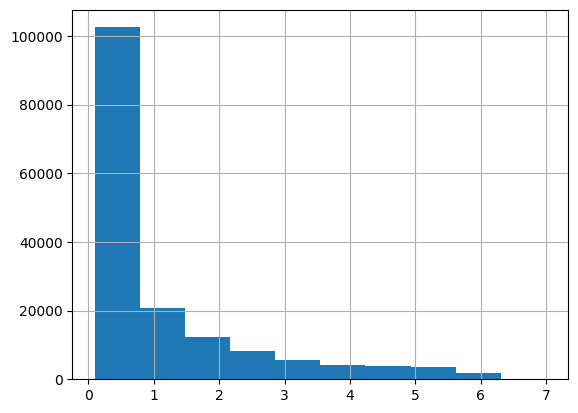

In [4]:
train = train[train["score"] > 0.1]
train["score"].hist()

In [5]:
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from tqdm import tqdm

train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:06<00:00, 42.72it/s]


In [6]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7698


event   tolerance
onset   12           0.331479
        36           0.672353
        60           0.745789
        90           0.790468
        120          0.813532
        150          0.836535
        180          0.850685
        240          0.868434
        300          0.877195
        360          0.884352
wakeup  12           0.281459
        36           0.696254
        60           0.760261
        90           0.796238
        120          0.822978
        150          0.840979
        180          0.854714
        240          0.877670
        300          0.891429
        360          0.903673
dtype: float64